# Import libraries and data

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import glob
import re
from datetime import datetime
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
#Display all the columns of the dataframe
pd.set_option('display.max_columns', None)

The dataset that I will use for the project to train my models, contains features of Spotify tracks and the source of it is https://www.kaggle.com/

In [3]:
tracks = pd.read_csv('track_features.csv')

In [4]:
tracks.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [5]:
tracks.isna().any()

Unnamed: 0          False
track_id            False
artists              True
album_name           True
track_name           True
popularity          False
duration_ms         False
explicit            False
danceability        False
energy              False
key                 False
loudness            False
mode                False
speechiness         False
acousticness        False
instrumentalness    False
liveness            False
valence             False
tempo               False
time_signature      False
track_genre         False
dtype: bool

We will see if there are any columns with null values. The fields with null values (artists,album_name,track_name) will not play any role in our analysis. So we can remove them and there is no action needed from us to handle null values.

No we will se some general characteristics of the numeric features

In [6]:
tracks.describe()

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.000000,114000.000000,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,56999.500000,33.238535,2.280292e+05,0.566800,0.641383,5.309140,-8.258960,0.637553,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837,3.904035
std,32909.109681,22.305078,1.072977e+05,0.173542,0.251529,3.559987,5.029337,0.480709,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197,0.432621
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28499.750000,17.000000,1.740660e+05,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750,4.000000
50%,56999.500000,35.000000,2.129060e+05,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,85499.250000,50.000000,2.615060e+05,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000,4.000000
max,113999.000000,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


As a first step, we will use only those columns that seem useful for the analysis. We wll insert them in a new data frame.

In [7]:
# keep only useful variables

df_tracks=tracks[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                'duration_ms',
                'time_signature']]

# Question 1
* Expore which Track Features Influence Valence

First we will plot all the distributions of the variables to see if there are any outliers. Then we will look at the correlation table across all variables to see if there are any variables that are correlated with each other.

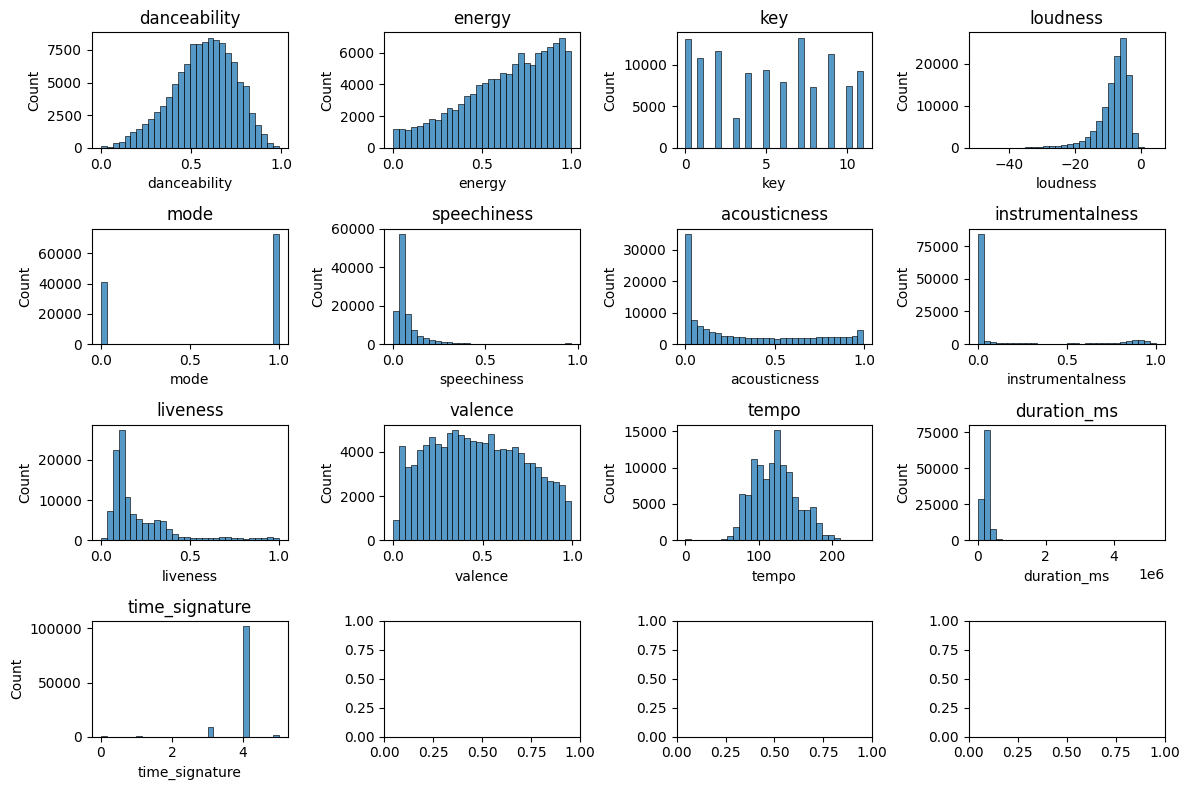

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 8))

axes = axes.flatten()

for i, column in enumerate(df_tracks.columns[:]):
    sns.histplot(df_tracks.iloc[:,i], kde=False, bins=30, ax=axes[i])
    axes[i].set_title(f'{column}')

plt.tight_layout()
plt.show()

In [9]:
corr=df_tracks.corr()
corr.style.background_gradient(cmap='coolwarm')

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
danceability,1.000000,0.134325,0.036469,0.259077,-0.069219,0.108626,-0.171533,-0.185606,-0.131617,0.477341,-0.050450,-0.073426,0.207218
energy,0.134325,1.000000,0.048006,0.761690,-0.078362,0.142509,-0.733906,-0.181879,0.184796,0.258934,0.247851,0.058523,0.187126
key,0.036469,0.048006,1.000000,0.038590,-0.135916,0.020418,-0.040937,-0.006823,-0.001600,0.034103,0.010917,0.008114,0.015065
loudness,0.259077,0.761690,0.038590,1.000000,-0.041764,0.060826,-0.589803,-0.433477,0.076899,0.279848,0.212446,-0.003470,0.191992
mode,-0.069219,-0.078362,-0.135916,-0.041764,1.000000,-0.046532,0.095553,-0.049955,0.014012,0.021953,0.000566,-0.035556,-0.024092
speechiness,0.108626,0.142509,0.020418,0.060826,-0.046532,1.000000,-0.002186,-0.089616,0.205219,0.036635,0.017273,-0.062600,-0.000011
acousticness,-0.171533,-0.733906,-0.040937,-0.589803,0.095553,-0.002186,1.000000,0.104027,-0.020700,-0.107070,-0.208224,-0.103788,-0.176138
instrumentalness,-0.185606,-0.181879,-0.006823,-0.433477,-0.049955,-0.089616,0.104027,1.000000,-0.079893,-0.324312,-0.050330,0.124371,-0.082580
liveness,-0.131617,0.184796,-0.001600,0.076899,0.014012,0.205219,-0.020700,-0.079893,1.000000,0.019086,0.000600,0.010321,-0.023651
valence,0.477341,0.258934,0.034103,0.279848,0.021953,0.036635,-0.107070,-0.324312,0.019086,1.000000,0.078273,-0.154479,0.133686


Looking at the correlation table, we can see that the variable that is directly correlated with valence is danceability. There also some other variables like energy and loudness that seem to have a significant correlation with the valence.

There are some categorical variables, so we'll convert them to dummy variables.

In [10]:
df_tracks = pd.get_dummies(df_tracks, columns=['key','mode','time_signature'])
df_tracks

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_0,mode_1,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,0.676,0.4610,-6.746,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,230666,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
1,0.420,0.1660,-17.235,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,149610,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
2,0.438,0.3590,-9.734,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,210826,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
3,0.266,0.0596,-18.515,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,201933,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False
4,0.618,0.4430,-9.681,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,198853,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,0.172,0.2350,-16.393,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,384999,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True
113996,0.174,0.1170,-18.318,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,385000,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
113997,0.629,0.3290,-10.895,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,271466,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False
113998,0.587,0.5060,-10.889,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,283893,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False


We will do a linear regression analysis with no adjustments and no feature selection to see how the model responds.

In [11]:
tracks_mod = smf.ols("valence ~ " + " + ".join(df_tracks.columns.difference(['valence'])), data=df_tracks)

tracks_res = tracks_mod.fit()
tracks_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     2648.
Date:                Sun, 07 Jan 2024   Prob (F-statistic):               0.00
Time:                        12:38:22   Log-Likelihood:                 18233.
No. Observations:              114000   AIC:                        -3.641e+04
Df Residuals:                  113974   BIC:                        -3.616e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.1581      0.004    -41.022      0.000      -0.166      -0.151
key_0[T.True]               -0.0004      0.002     -0.238      0.812      -0.004       0.003
key_1[T.True]               -0.0435      0.002    -22.185      0.000      -0.047      -0.040
key_10[T.True]              -0.0097      0.002     -4.212      0.000      -0.014      -0.005
key_11[T.True]              -0.0099      0.002     -4.701      0.000      -0.014      -0.006
key_2[T.True]               -0.0161      0.002     -8.483      0.000      -0.020      -0.012
key_3[T.True]               -0.0192      0.003     -5.907      0.000      -0.026      -0.013
key_4[T.True]               -0.0190      0.002     -8.965      0.000      -0.023      -0.015
key_5[T.True]                0.0007      0.002      0.320      0.749      -0.003       0.005
key_6[T.True]               -0.0181      0.002     -8.054      0.000      -0.022      -0.014
key_7[T.True]               -0.0111      0.002     -6.188      0.000      -0.015      -0.008
key_8[T.True]               -0.0194      0.002     -8.369      0.000      -0.024      -0.015
key_9[T.True]                0.0078      0.002      4.051      0.000       0.004       0.012
mode_0[T.True]              -0.0901      0.002    -43.615      0.000      -0.094      -0.086
mode_1[T.True]              -0.0680      0.002    -33.836      0.000      -0.072      -0.064
time_signature_0[T.True]     0.0878      0.014      6.449      0.000       0.061       0.114
time_signature_1[T.True]    -0.0600      0.006     -9.512      0.000      -0.072      -0.048
time_signature_3[T.True]    -0.0732      0.004    -18.973      0.000      -0.081      -0.066
time_signature_4[T.True]    -0.0584      0.004    -16.184      0.000      -0.065      -0.051
time_signature_5[T.True]    -0.0542      0.005    -10.469      0.000      -0.064      -0.044
acousticness                 0.1824      0.003     64.551      0.000       0.177       0.188
danceability                 0.6936      0.004    176.708      0.000       0.686       0.701
duration_ms              -2.381e-07   5.81e-09    -40.969      0.000   -2.49e-07   -2.27e-07
energy                       0.4574      0.005     94.330      0.000       0.448       0.467
instrumentalness            -0.1971      0.002    -85.112      0.000      -0.202      -0.193
liveness                     0.0183      0.003      5.321      0.000       0.012       0.025
loudness                    -0.0078      0.000    -35.389      0.000      -0.008      -0.007
speechiness                 -0.2271      0.006    -36.662      0.000      -0.239      -0.215
tempo                        0.0006   2.15e-05     27.503      0.000       0.001       0.001
==============================================================================
Omnibus:                    

One method we will explore is forward stepwise selection to identify the features that influence valence. We could also use best subset selection, but this method requires fewer columns than our dataset, so we will continue with forward stepwise selection.

In [12]:
def process_subset(y, data, feature_set):
    X = data.loc[:, feature_set].to_numpy(dtype=int)
    X = sm.add_constant(X)
    names = ['intercept']
    names.extend(feature_set)
    model = sm.OLS(y, X)
    model.data.xnames = names
    regr = model.fit()
    return regr

In [13]:
def forward_add_variable(data, exog, selected, to_select):
    best_rsquared = 0
    best_model = None
    best_column = None
    y = data.loc[:, exog]
    
    for column in to_select:
        new_selected = selected + [column]
        regr = process_subset(y, data, new_selected)
        if regr.rsquared > best_rsquared:
            best_rsquared = regr.rsquared
            best_model = regr
            best_column = column
    
    return best_model, best_column

In [14]:
def forward_stepwise_selection(data, exog):

    best_models = []
    best_model = None
    selected = []
    to_select = [ x for x in data.columns if x != exog ]

    p = len(to_select) + 1

    for i in range(1, p):
        print(f'Finding the best model for {i} variable{"s" if i > 1 else ""}')
        model, best_column = forward_add_variable(data, exog, selected, to_select)
        selected.append(best_column)
        to_select.remove(best_column)
        if not best_model or model.rsquared_adj > best_model.rsquared_adj:
            best_model = model
        print(selected, model.rsquared_adj)
        best_models.append(model)
        
    print(f'Fitted {1 + p*(p+1)//2} models')
    return best_model, best_models

In [15]:
best_model, best_models = forward_stepwise_selection(df_tracks, 'valence')
print('Best overall model:', len(best_model.model.exog_names) - 1, 
      best_model.model.exog_names)

Finding the best model for 1 variable
['loudness'] 0.07796314443449015
Finding the best model for 2 variables
['loudness', 'duration_ms'] 0.10153248051019237
Finding the best model for 3 variables
['loudness', 'duration_ms', 'time_signature_4'] 0.1147566266198351
Finding the best model for 4 variables
['loudness', 'duration_ms', 'time_signature_4', 'key_1'] 0.11628197656958017
Finding the best model for 5 variables
['loudness', 'duration_ms', 'time_signature_4', 'key_1', 'time_signature_0'] 0.11727820876064743
Finding the best model for 6 variables
['loudness', 'duration_ms', 'time_signature_4', 'key_1', 'time_signature_0', 'mode_0'] 0.11818361824313595
Finding the best model for 7 variables
['loudness', 'duration_ms', 'time_signature_4', 'key_1', 'time_signature_0', 'mode_0', 'key_9'] 0.11864962265135093
Finding the best model for 8 variables
['loudness', 'duration_ms', 'time_signature_4', 'key_1', 'time_signature_0', 'mode_0', 'key_9', 'tempo'] 0.11906004232693079
Finding the best mo

In [16]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     920.8
Date:                Sun, 07 Jan 2024   Prob (F-statistic):               0.00
Time:                        12:41:21   Log-Likelihood:                -532.66
No. Observations:              114000   AIC:                             1101.
Df Residuals:                  113982   BIC:                             1275.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            0.5645      0.005    116.869      0.000       0.555       0.574
loudness             0.0125      0.000     82.443      0.000       0.012       0.013
duration_ms       -3.79e-07   6.73e-09    -56.344      0.000   -3.92e-07   -3.66e-07
time_signature_4     0.1004      0.003     38.574      0.000       0.095       0.105
key_1               -0.0446      0.003    -16.296      0.000      -0.050      -0.039
time_signature_0    -0.1979      0.019    -10.186      0.000      -0.236      -0.160
mode_0              -0.0171      0.002    -11.127      0.000      -0.020      -0.014
key_9                0.0070      0.003      2.603      0.009       0.002       0.012
tempo                0.0002   2.48e-05      7.529      0.000       0.000       0.000
key_2               -0.0255      0.003     -9.558      0.000      -0.031      -0.020
energy              -0.2798      0.046     -6.088      0.000      -0.370      -0.190
key_4               -0.0226      0.003     -7.696      0.000      -0.028      -0.017
key_3               -0.0299      0.004     -6.942      0.000      -0.038      -0.021
key_8               -0.0193      0.003     -6.085      0.000      -0.026      -0.013
key_6               -0.0178      0.003     -5.762      0.000      -0.024      -0.012
key_7               -0.0109      0.003     -4.264      0.000      -0.016      -0.006
time_signature_5     0.0171      0.006      2.771      0.006       0.005       0.029
key_11              -0.0041      0.003     -1.404      0.160      -0.010       0.002
==============================================================================
Omnibus:                     4437.111   Durbin-Watson:                   1.360
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2413.180
Skew:                           0.189   Prob(JB):                         0.00
Kurtosis:                       2.396   Cond. No.                     1.61e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We see that the model after stepwise forward selection provides worse R squared than the initial model. It's essential to note that forward stepwise selection has its limitations and may not always find the globally optimal subset of features. So, we can't find the most significant features in that way.

We are going to select the most significant features based on the correlation table

In [35]:
corr=df_tracks.corr()
corr.style.background_gradient(cmap='coolwarm')

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_0,mode_1,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
danceability,1.000000,0.134325,0.259077,0.108626,-0.171533,-0.185606,-0.131617,0.477341,-0.050450,-0.073426,-0.012420,0.020627,-0.042412,-0.020047,-0.017901,0.000167,0.021831,-0.005378,0.020651,-0.017056,0.018273,0.039198,0.069219,-0.069219,-0.120262,-0.076868,-0.220701,0.264233,-0.078401
energy,0.134325,1.000000,0.761690,0.142509,-0.733906,-0.181879,0.184796,0.258934,0.247851,0.058523,-0.046043,0.053042,-0.032077,-0.050881,-0.007038,-0.029221,0.038098,-0.008281,0.022381,0.001266,-0.000214,0.054080,0.078362,-0.078362,-0.076559,-0.067013,-0.223207,0.258316,-0.078793
loudness,0.259077,0.761690,1.000000,0.060826,-0.589803,-0.433477,0.076899,0.279848,0.212446,-0.003470,-0.030883,0.024506,-0.026624,-0.035176,-0.002140,-0.012613,0.030747,-0.009570,0.029584,-0.000558,-0.011172,0.043168,0.041764,-0.041764,-0.102131,-0.085221,-0.204889,0.256533,-0.093105
speechiness,0.108626,0.142509,0.060826,1.000000,-0.002186,-0.089616,0.205219,0.036635,0.017273,-0.062600,-0.043286,0.059511,-0.024768,-0.006171,-0.012113,-0.015689,0.031393,-0.016754,0.017683,-0.008604,0.013714,0.017380,0.046532,-0.046532,-0.029505,0.036519,0.029632,-0.077745,0.108990
acousticness,-0.171533,-0.733906,-0.589803,-0.002186,1.000000,0.104027,-0.020700,-0.107070,-0.208224,-0.103788,0.040239,-0.062792,0.034255,0.056270,0.010469,0.033459,-0.044137,0.006865,-0.024800,0.006700,0.013562,-0.061704,-0.095553,0.095553,0.021041,0.076849,0.226424,-0.257138,0.078421
instrumentalness,-0.185606,-0.181879,-0.433477,-0.089616,0.104027,1.000000,-0.079893,-0.324312,-0.050330,0.124371,-0.009295,0.023447,0.000736,0.011864,-0.014271,-0.002500,0.003955,0.005419,-0.007196,-0.018073,0.019990,-0.007909,0.049955,-0.049955,0.058855,0.045382,0.068815,-0.095803,0.035309
liveness,-0.131617,0.184796,0.076899,0.205219,-0.020700,-0.079893,1.000000,0.019086,0.000600,0.010321,-0.003383,-0.011063,0.016939,-0.017783,0.021210,0.002797,-0.011661,0.012318,-0.029585,0.011875,-0.009681,0.003374,-0.014012,0.014012,0.045302,0.015811,-0.000941,-0.011769,0.005756
valence,0.477341,0.258934,0.279848,0.036635,-0.107070,-0.324312,0.019086,1.000000,0.078273,-0.154479,0.016132,-0.034142,-0.021274,-0.021840,-0.016683,0.011238,-0.000456,0.002447,0.005698,0.025369,0.005716,0.019902,-0.021953,0.021953,-0.067189,-0.050304,-0.149361,0.177264,-0.054761
tempo,-0.050450,0.247851,0.212446,0.017273,-0.208224,-0.050330,0.000600,0.078273,1.000000,0.024346,-0.007891,0.012506,-0.006184,-0.023742,0.004493,-0.027403,0.012833,0.007573,0.006321,0.016710,-0.007558,0.002947,-0.000566,0.000566,-0.148561,-0.043120,0.002493,0.044535,-0.038591
duration_ms,-0.073426,0.058523,-0.003470,-0.062600,-0.103788,0.124371,0.010321,-0.154479,0.024346,1.000000,-0.019833,0.008755,0.003324,-0.008355,0.011127,-0.009315,0.006264,0.006880,-0.009354,-0.000076,0.008374,0.000786,0.035556,-0.035556,-0.019322,-0.017127,-0.015518,0.034082,-0.031769


In [17]:
#corr.to_excel('corr.xlsx')

We observe that the feature that contributes less to the valence is the "key". So we keep the rest of them. And run again the linear regression

In [18]:
df_tracks=tracks[['danceability', 'energy', 'loudness', 'mode', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                'duration_ms',
                'time_signature']]

df_tracks = pd.get_dummies(df_tracks, columns=['mode','time_signature'])

In [19]:
tracks_mod = smf.ols("valence ~ " + " + ".join(df_tracks.columns.difference(['valence'])), data=df_tracks)

tracks_res = tracks_mod.fit()
tracks_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                valence   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     4676.
Date:                Sun, 07 Jan 2024   Prob (F-statistic):               0.00
Time:                        12:43:00   Log-Likelihood:                 18001.
No. Observations:              114000   AIC:                        -3.597e+04
Df Residuals:                  113985   BIC:                        -3.583e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.1655      0.004    -40.890      0.000      -0.173      -0.158
mode_0[T.True]              -0.0936      0.002    -43.445      0.000      -0.098      -0.089
mode_1[T.True]              -0.0719      0.002    -34.372      0.000      -0.076      -0.068
time_signature_0[T.True]     0.0825      0.014      6.048      0.000       0.056       0.109
time_signature_1[T.True]    -0.0619      0.006     -9.792      0.000      -0.074      -0.050
time_signature_3[T.True]    -0.0735      0.004    -19.055      0.000      -0.081      -0.066
time_signature_4[T.True]    -0.0583      0.004    -16.187      0.000      -0.065      -0.051
time_signature_5[T.True]    -0.0543      0.005    -10.478      0.000      -0.064      -0.044
acousticness                 0.1846      0.003     65.372      0.000       0.179       0.190
danceability                 0.6929      0.004    176.392      0.000       0.685       0.701
duration_ms              -2.392e-07   5.82e-09    -41.093      0.000   -2.51e-07   -2.28e-07
energy                       0.4564      0.005     93.998      0.000       0.447       0.466
instrumentalness            -0.1987      0.002    -85.731      0.000      -0.203      -0.194
liveness                     0.0204      0.003      5.945      0.000       0.014       0.027
loudness                    -0.0078      0.000    -35.323      0.000      -0.008      -0.007
speechiness                 -0.2357      0.006    -38.115      0.000      -0.248      -0.224
tempo                        0.0006   2.15e-05     27.493      0.000       0.001       0.001
==============================================================================
Omnibus:                      658.748   Durbin-Watson:                   1.542
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              484.224
Skew:                           0.051   Prob(JB):                    7.11e-106
Kurtosis:                       2.697   Cond. No.                     4.93e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.98e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The R squared is the same as before and we have removed the key, which seems unnecessary.

### Conclusion

If we combine the 2 methods above with the coefficients and the strong correlations, the features that seem to be very significant for the valence are, danceability, energy, instrumentalness, loudness durations_ms and acousticness

# Question 2
* Predict Valence

In [27]:
df_tracks=tracks[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                'duration_ms',
                'time_signature']]

df_tracks = pd.get_dummies(df_tracks, columns=['key','time_signature'])

## Random Forest

In [35]:
df_tracks=tracks[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                'duration_ms',
                'time_signature']]

df_tracks = pd.get_dummies(df_tracks, columns=['key','time_signature'])

Mean Absolute Error: 0.10561924943207326


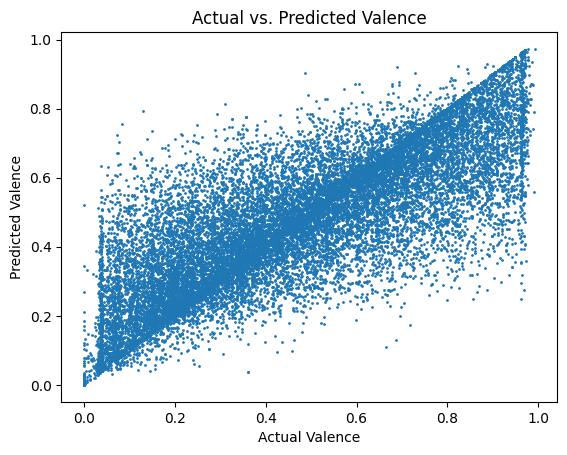

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Step 1: Train-Test Split
X = df_tracks.drop('valence', axis=1)
y = df_tracks['valence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




# Step 2: Set the regressor
#rf_model = RandomForestRegressor(n_estimators= 100, min_samples_split= 2, min_samples_leaf=1, max_depth=None)
rf_model = RandomForestRegressor()

# Step 3: Train the Model
rf_model.fit(X_train, y_train)


# Step 4: Evaluate the Model
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')



# Step 5: Evaluate Results
plt.scatter(y_test, y_pred,s=1)
plt.xlabel('Actual Valence')
plt.ylabel('Predicted Valence')
plt.title('Actual vs. Predicted Valence')
plt.show()


### Find hyperparameters and most important features

In [103]:
from sklearn.model_selection import RandomizedSearchCV

# Step 1: Train-Test Split
X = df_tracks.drop('valence', axis=1)
y = df_tracks['valence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Set the regressor
rf_model = RandomForestRegressor()

# Step 3: Define the parameter distribution for hyperparameter tuning
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Step 4: Perform randomized search with cross-validation
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Step 5: Get the best hyperparameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Step 6: Train the final model with the best hyperparameters
final_rf_model = RandomForestRegressor(**best_params)
final_rf_model.fit(X_train, y_train)

# Step 7: Evaluate the final model
y_pred = final_rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error on Test Set: {mae}')


Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Mean Absolute Error on Test Set: 0.10650947410079369


Using the method RandomizedSearchCV, we tried tou find the best possible hyperaparameters in order to improve the Random forest model. In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. Below we can see the results of this method 

Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Mean Absolute Error on Test Set: 0.10650947410079369

Now we are going to find the the features influence the valence metric, using the feature importances. Below we see the influence of the features in a descending order.

In [32]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Create a DataFrame to display feature importance scores
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance
print(importance_df)

             Feature  Importance
0       danceability    0.284230
1             energy    0.116802
6   instrumentalness    0.099103
9        duration_ms    0.087206
4        speechiness    0.075489
5       acousticness    0.075329
8              tempo    0.071558
2           loudness    0.070104
7           liveness    0.066268
3               mode    0.007153
10             key_0    0.004317
11             key_1    0.004175
17             key_7    0.004168
19             key_9    0.003966
12             key_2    0.003834
14             key_4    0.003634
15             key_5    0.003398
21            key_11    0.003337
16             key_6    0.003234
20            key_10    0.003197
18             key_8    0.003116
13             key_3    0.001988
25  time_signature_4    0.001881
24  time_signature_3    0.001491
26  time_signature_5    0.000623
23  time_signature_1    0.000370
22  time_signature_0    0.000027


In these models, it appears that the characteristics that most influence valence are danceability and energy. It makes sense because the more danceable and the more energetic a song is, the more positive it is.

mean_absolute_error: 0.16922437354603323


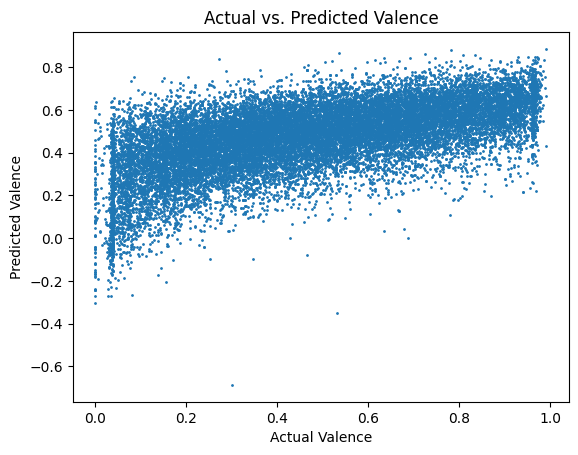

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler



# Step 1: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(df_tracks.drop('valence', axis=1), df_tracks['valence'], test_size=0.2, random_state=42)

# Step 2: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Model Selection
lr = LinearRegression()

# Step 4: Model Training
lr.fit(X_train_scaled, y_train)

# Step 5: Model Evaluation
predictions = lr.predict(X_test_scaled)
mse = mean_absolute_error(y_test, predictions)
print(f'mean_absolute_error: {mse}')



plt.scatter(y_test, predictions,s=1)
plt.xlabel('Actual Valence')
plt.ylabel('Predicted Valence')
plt.title('Actual vs. Predicted Valence')
plt.show()

## Ridge

In [ ]:
df_tracks=tracks[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                'duration_ms',
                'time_signature']]

df_tracks = pd.get_dummies(df_tracks, columns=['key','time_signature'])

df_tracks.drop([''], axis=1)

mean_absolute_error: 0.16891755017158572


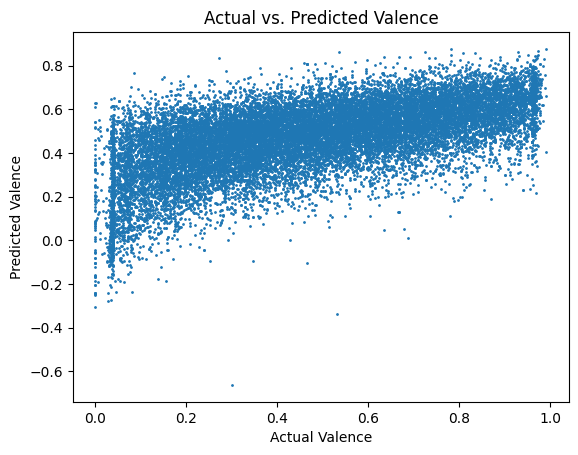

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler



# Step 1: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(df_tracks.drop('valence', axis=1), df_tracks['valence'], test_size=0.2, random_state=42)

# Step 2: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Model Selection
ridge = Ridge(alpha=0.001)

# Step 4: Model Training
ridge.fit(X_train_scaled, y_train)

# Step 5: Model Evaluation
predictions = ridge.predict(X_test_scaled)
mse = mean_absolute_error(y_test, predictions)
print(f'mean_absolute_error: {mse}')

plt.scatter(y_test, predictions,s=1)
plt.xlabel('Actual Valence')
plt.ylabel('Predicted Valence')
plt.title('Actual vs. Predicted Valence')
plt.show()

### Find hyperparameters and most important features

In [101]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

# Step 1: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(df_tracks.drop('valence', axis=1), df_tracks['valence'], test_size=0.2, random_state=42)

# Step 2: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Model Selection with Hyperparameter Tuning
pipeline = Pipeline([
    ('regression', Ridge())
])

# Define the hyperparameter grid
param_grid = {
    'regression__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_alpha = grid_search.best_params_['regression__alpha']
print("Best alpha:", best_alpha)

# Train the final model with the best hyperparameters
final_lr = Ridge(alpha=best_alpha)
final_lr.fit(X_train_scaled, y_train)

# Make predictions and evaluate the model
predictions = final_lr.predict(X_test_scaled)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error on Test Set: {mae}')


Best alpha: 0.001
Mean Absolute Error on Test Set: 0.16891755017158572


The best alpha =0.001 in order to improve the model and get the best performance. On the other hand, we have again a big mean absolute(mae~0.168) error and it seems that we will not select this model as the best one.

In [41]:
import numpy as np


coefficients = ridge.coef_

coefficients_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})
coefficients_df = coefficients_df.sort_values(by='Coefficient', key=lambda x: np.abs(x), ascending=False)

# Display the feature coefficients
print(coefficients_df)


             Feature  Coefficient
0       danceability     0.119915
1             energy     0.115042
5       acousticness     0.060666
6   instrumentalness    -0.060292
2           loudness    -0.037971
9        duration_ms    -0.025448
4        speechiness    -0.024218
8              tempo     0.017797
3               mode     0.010574
11             key_1    -0.009238
19             key_9     0.006160
22  time_signature_0     0.005978
15             key_5     0.003730
10             key_0     0.003597
7           liveness     0.003298
24  time_signature_3    -0.002496
18             key_8    -0.002278
16             key_6    -0.001779
14             key_4    -0.001260
25  time_signature_4     0.001028
26  time_signature_5     0.000889
13             key_3    -0.000877
20            key_10     0.000655
12             key_2    -0.000649
17             key_7     0.000523
23  time_signature_1     0.000332
21            key_11     0.000243


In this model, it appears that the characteristics that most influence valence are danceability and energy again. It makes sense because the more danceable and the more energetic a song is, the more positive it is.

## XG Boost

In [48]:
df_tracks=tracks[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                'duration_ms',
                'time_signature']]

df_tracks = pd.get_dummies(df_tracks, columns=['key','time_signature'])

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb


X_train, X_test, y_train, y_test = train_test_split(df_tracks.drop('valence', axis=1), df_tracks['valence'], test_size=0.2, random_state=42)

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [50]:
y_pred = xgb_reg.predict(X_test)
mean_absolute_error(y_test, y_pred)

0.13534802484887207

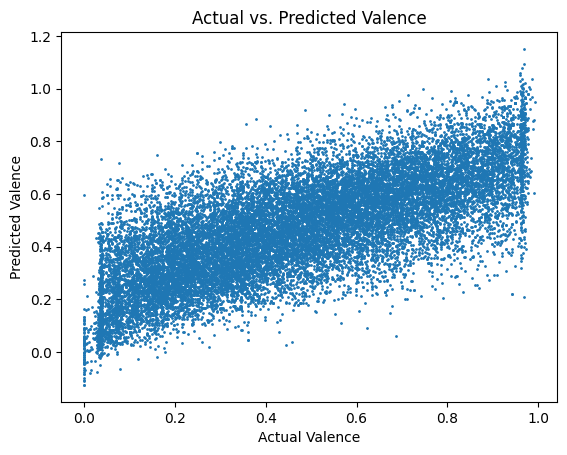

In [51]:
plt.scatter(y_test, y_pred,s=1)
plt.xlabel('Actual Valence')
plt.ylabel('Predicted Valence')
plt.title('Actual vs. Predicted Valence')
plt.show()

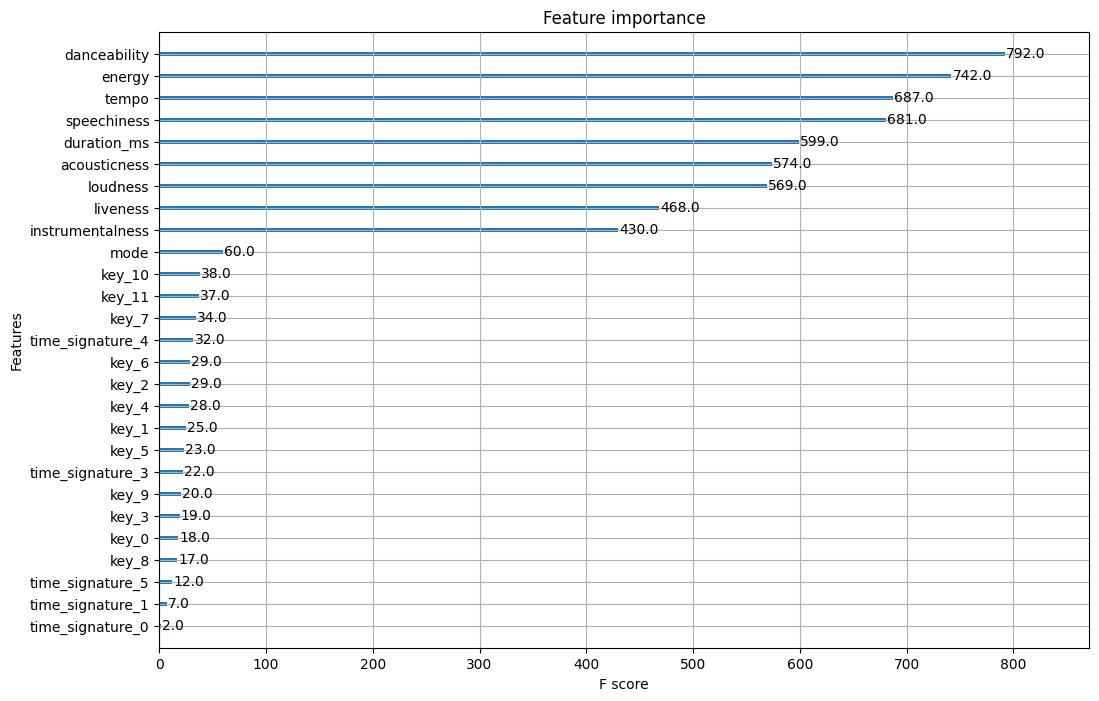

In [54]:
fig = plt.figure(figsize=(12, 8))
#xgb_reg.get_booster().feature_names = df_tracks.feature_names
_ = xgb.plot_importance(xgb_reg, ax = fig.gca())

### Find hyperparameters using Optuna

We use optuna in order to decide which are the best hyperparameters for the model.

In [55]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'alpha': trial.suggest_float('alpha', 0, 10),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1)
    }

    xgb_reg = xgb.XGBRegressor(**params)

    # Use cross-validation to evaluate the model
    score = cross_val_score(xgb_reg, X_train, y_train, cv=3, scoring='neg_mean_absolute_error')
    mae = -score.mean()
    return mae

# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the final model with the best hyperparameters
final_xgb_reg = xgb.XGBRegressor(**best_params)
final_xgb_reg.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = final_xgb_reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error on Test Set:", mae)


[I 2024-01-07 14:26:13,972] A new study created in memory with name: no-name-b9e7f8c2-627c-437f-b378-e98436583249
[I 2024-01-07 14:26:16,938] Trial 0 finished with value: 0.15524888098192607 and parameters: {'colsample_bytree': 0.3637851819173852, 'learning_rate': 0.08547131980682014, 'max_depth': 12, 'alpha': 8.30696656462666, 'n_estimators': 94, 'subsample': 0.6498565292811624, 'gamma': 0.5595789800480839}. Best is trial 0 with value: 0.15524888098192607.
[I 2024-01-07 14:26:20,719] Trial 1 finished with value: 0.14243016276554007 and parameters: {'colsample_bytree': 0.9769000761038518, 'learning_rate': 0.09324187367934199, 'max_depth': 6, 'alpha': 0.3377821632095557, 'n_estimators': 100, 'subsample': 0.5600060030811126, 'gamma': 0.19306644706497733}. Best is trial 1 with value: 0.14243016276554007.
[I 2024-01-07 14:26:25,725] Trial 2 finished with value: 0.1485330059411513 and parameters: {'colsample_bytree': 0.9771520129164399, 'learning_rate': 0.04845314900099703, 'max_depth': 11,

Best Hyperparameters: {'colsample_bytree': 0.7324673761330079, 'learning_rate': 0.09142938205253835, 'max_depth': 11, 'alpha': 0.023456872663243755, 'n_estimators': 190, 'subsample': 0.9614017350959088, 'gamma': 0.04128081538541248}
Mean Absolute Error on Test Set: 0.1195938756744416


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb


X_train, X_test, y_train, y_test = train_test_split(df_tracks.drop('valence', axis=1), df_tracks['valence'], test_size=0.2, random_state=42)

xgb_reg = xgb.XGBRegressor(** best_params)
xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_test)
mean_absolute_error(y_test, y_pred)




0.1195938756744416

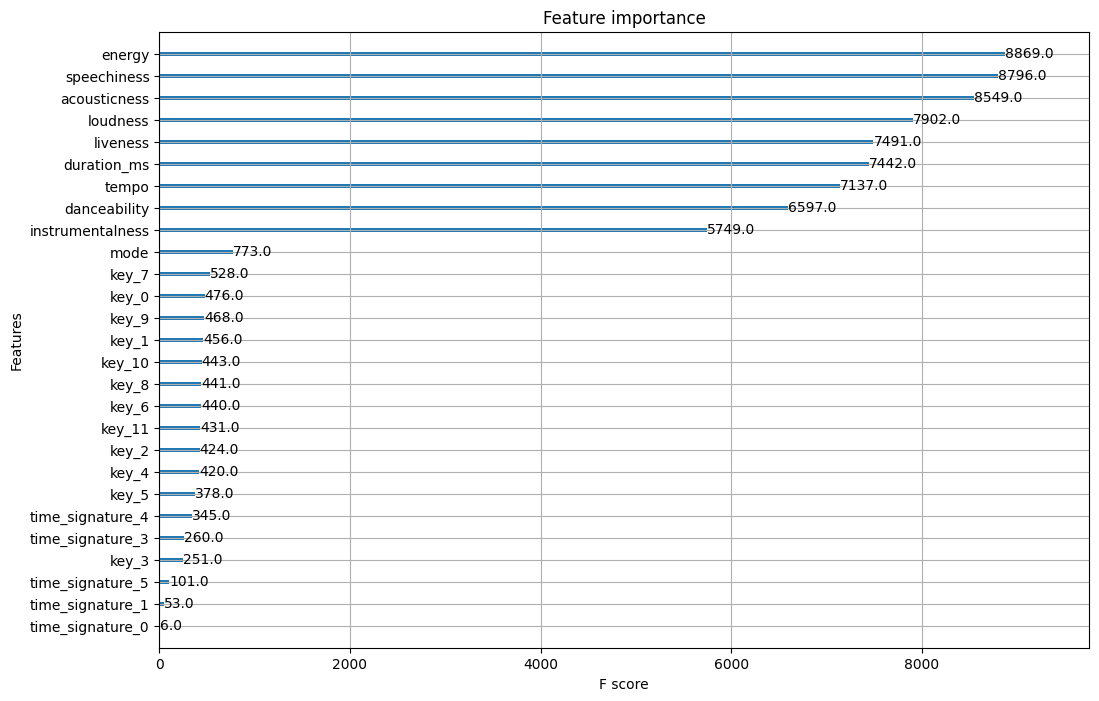

In [57]:
fig = plt.figure(figsize=(12, 8))
#xgb_reg.get_booster().feature_names = df_tracks.feature_names
_ = xgb.plot_importance(xgb_reg, ax = fig.gca())

We can see from the graph that the 3 most important features for the model are energy speechiness and acousticness. One thing that surprises me is that it does not consider danceability as one of the most important features, as the previous models did. After using Optuna to find the best hyperparameters, the mean absolute error was reduced significantly from the initial. We see that the model was imroved but we still dont get the best mean absolute error. The best hyperparameters for the model are shown below.

In [58]:
best_params

{'colsample_bytree': 0.7324673761330079,
 'learning_rate': 0.09142938205253835,
 'max_depth': 11,
 'alpha': 0.023456872663243755,
 'n_estimators': 190,
 'subsample': 0.9614017350959088,
 'gamma': 0.04128081538541248}

# Results for the holdout testing dataset

## Read Holdout dataset

In [66]:
file_path = 'spotify_ids_holdout.txt'  # Replace with the actual path

with open(file_path, 'r') as file:
    spotify_ids_list = [line.strip() for line in file]


In [67]:
from spotify_config import config

client_credentials_manager = SpotifyClientCredentials(config['client_id'],
                                                      config['client_secret'])
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [68]:
features = {}
all_track_ids = spotify_ids_list

In [70]:
start = 0
num_tracks = 100
while start < len(all_track_ids):
    print(f'getting from {start} to {start+num_tracks}')
    tracks_batch = all_track_ids[start:start+num_tracks]
    features_batch = sp.audio_features(tracks_batch)
    features.update({ track_id : track_features 
                     for track_id, track_features in zip(tracks_batch, features_batch) })
    start += num_tracks

getting from 0 to 100
getting from 100 to 200
getting from 200 to 300
getting from 300 to 400
getting from 400 to 500
getting from 500 to 600
getting from 600 to 700
getting from 700 to 800
getting from 800 to 900
getting from 900 to 1000
getting from 1000 to 1100


In [94]:
holdout_dataset = pd.DataFrame.from_dict(features, orient='index')


In [95]:
holdout_dataset=holdout_dataset[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                'duration_ms',
                'time_signature']]

holdout_dataset = pd.get_dummies(holdout_dataset, columns=['key','time_signature'])

I observed that the "time_signature_0" is missing from the test dataset and I added the value that shows up more frequently in the training dataset.

In [98]:
holdout_dataset.insert(loc=23, column='time_signature_0', value=False)

In [99]:
holdout_dataset

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
7x9aauaA9cu6tyfpHnqDLo,0.802,0.832,-4.107,1,0.0434,0.31100,0.000000,0.0815,0.8900,124.997,185427,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
56y1jOTK0XSvJzVv9vHQBK,0.864,0.556,-7.683,0,0.1940,0.25500,0.000004,0.1120,0.7260,99.974,230480,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3rUGC1vUpkDG9CZFHMur1t,0.750,0.733,-3.180,0,0.0319,0.25600,0.000000,0.1140,0.8440,111.018,131872,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
01qFKNWq73UfEslI0GvumE,0.853,0.824,-3.287,1,0.1030,0.03220,0.000000,0.0859,0.8880,108.044,201812,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2YSzYUF3jWqb9YP9VXmpjE,0.663,0.670,-8.399,1,0.2710,0.04640,0.000089,0.2050,0.1380,136.952,260111,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3fDTzkvrOo5xQIO480Qmsb,0.538,0.783,-2.565,0,0.2220,0.01130,0.000000,0.2810,0.5530,75.388,259080,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
4Ls53fBNVfaXTROBi6X8Hw,0.485,0.545,-7.924,1,0.0336,0.06510,0.005470,0.0642,0.0385,150.185,123891,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
5PLqXnvHH7Gh6CcfiUEr7e,0.600,0.600,-7.715,0,0.1150,0.00388,0.000000,0.1220,0.5950,90.435,194920,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False
0hDE81j4N2DPLbEY4tiCDs,0.750,0.830,-3.544,1,0.0683,0.11500,0.000000,0.7650,0.6880,104.937,182857,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


## Final Evaluation

Now that we have read the holdout dataset, we will train our model on the entire training dataset. For the final model I decided to keep all the features of the dataset because each time I removed a feature the performance of the model got worse. The model I will use is the RandomForest, which had the best performance during the testing phase. After the RandomizedSearchCV, I discovered that the best hyperparameters were all the default ones. So I will keep the default hyperparameters.

In [102]:
df_tracks=tracks[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                'duration_ms',
                'time_signature']]

df_tracks = pd.get_dummies(df_tracks, columns=['key','time_signature'])

In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


X = df_tracks.drop('valence', axis=1)
y = df_tracks['valence']

rf_final_model = RandomForestRegressor()
rf_final_model.fit(X, y)

RandomForestRegressor()

In [106]:
y_pred = rf_final_model.predict(holdout_dataset.drop('valence', axis=1))
mae = mean_absolute_error(holdout_dataset['valence'], y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.13415364343832023


The Mean Absolute Error of the final  model is 0.1341